# Link stream

**Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import itertools
import scipy.sparse as sp
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import sknetwork as sk
import networkx as nx

import dgl
import dgl.function as fn
from dgl.nn.pytorch.conv import GraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F

Using backend: pytorch


## 1. Data

In [3]:
path = '/Users/simondelarue/Documents/MS_BGD-Telecom_PARIS/Stage/1_data'

Data comes from [SFHH Conference Dataset](http://www.sociopatterns.org/datasets/sfhh-conference-data-set/).

In [4]:
# df = pd.read_pickle(f'{path}/preprocessed_data/aggregated_data.pkl') # SF2H conference aggregated over time intervals
df = pd.read_csv(f'{path}/tij_SFHH.dat_', header=None, names=['t', 'i', 'j'], delimiter=' ') # SF2H conference
print(df.shape)

(70261, 3)


In [5]:
df_preproc = pd.read_pickle(f'{path}/preprocessed_data/SF2H.pkl')
df_preproc.head()

,t,i,j,src,dest
0,32520,1467,1591,36,144
1,32560,1513,1591,75,144
2,32700,1591,1467,144,36
3,32720,1591,1467,144,36
4,32740,1591,1467,144,36


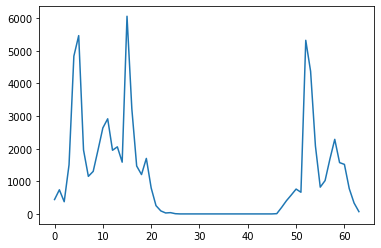

In [28]:
df = []
for i in np.arange(0, 64):
    df.append(len(df_preproc[(df_preproc['t']>df_preproc['t'].min()+(i*1800)) & (df_preproc['t']<=df_preproc['t'].min()+((i+1)*1800))]))
plt.plot(df);

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70261 entries, 0 to 70260
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   t       70261 non-null  int64
 1   i       70261 non-null  int64
 2   j       70261 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


**Create graph**

In [6]:
src_tens = torch.tensor(df_preproc['src'].values)
dest_tens = torch.tensor(df_preproc['dest'].values)

g = dgl.graph((src_tens, dest_tens))
g.edata['timestamp'] = torch.from_numpy(df_preproc['t'].to_numpy())

# GRAPH
g

Graph(num_nodes=403, num_edges=70261,
      ndata_schemes={}
      edata_schemes={'timestamp': Scheme(shape=(), dtype=torch.int64)})

### Tutorial : Link prediction with GNN

https://docs.dgl.ai/en/0.6.x/tutorials/blitz/4_link_predict.html

### Positive-negative samples  

Initial graph $\mathcal{G}$ is divided into training and test data, but also into positive and negative samples : 
* The training and test sets are divided according to $i^{th}$ quantile of time.
* The negative edges are randomly sampled among all the possibilities of edges and time.

In [7]:
def sample_random_node(g, n):
    return int(np.random.choice(g.nodes().numpy(), n))

def sample_random_time(timerange, n, mask):
    return int(np.random.choice(timerange[mask], n))

def make_edge_list(src, dest, t, mask):
    return [(u, v, t) for u, v, t in zip(src[mask].numpy(), dest[mask].numpy(), t[mask].numpy())]

In [8]:
def train_test_split(g, val_size=0.15, test_size=0.15):

    print('\nSplitting graph ...')

    # Compute validation time and test time
    val_cut = 1 - val_size - test_size
    test_cut = 1 - test_size
    val_time, test_time = np.quantile(g.edata['timestamp'], [val_cut, test_cut])

    # Split edge set for training, validation and test
    # Edges are divided into 2 groups : positive (link in graph) and negative (no link in graph)

    source, dest = g.edges()
    timestamp = g.edata['timestamp']

    # Masks for datasets filtering
    train_mask = g.edata['timestamp'] <= val_time
    val_mask = torch.logical_and(g.edata['timestamp'] > val_time, g.edata['timestamp'] <= test_time)
    test_mask = g.edata['timestamp'] > test_time

    eids = np.arange(g.number_of_edges())
    val_nb_edge = len(source[val_mask])
    test_nb_edge = len(source[test_mask])
    train_nb_edge = len(eids) - test_nb_edge - val_nb_edge

    # -- Positive edges --
    # Postiive edges are used to create positive graphs according to splits

    train_pos_g = dgl.graph((source[train_mask], dest[train_mask]), num_nodes=g.number_of_nodes())
    val_pos_g = dgl.graph((source[val_mask], dest[val_mask]), num_nodes=g.number_of_nodes())
    test_pos_g = dgl.graph((source[test_mask], dest[test_mask]), num_nodes=g.number_of_nodes())
    train_pos_g.edata['timestamp'] = timestamp[train_mask]
    val_pos_g.edata['timestamp'] = timestamp[val_mask]
    test_pos_g.edata['timestamp'] = timestamp[test_mask]

    # -- Negative edges --
    # Negative edges are sampled randomly and used to create negative graphs according to splits

    edge_list_train = make_edge_list(source, dest, timestamp, train_mask)
    edge_list_val = make_edge_list(source, dest, timestamp, val_mask)
    edge_list_test = make_edge_list(source, dest, timestamp, test_mask)
    timerange = np.arange(int(g.edata['timestamp'].min()), int(g.edata['timestamp'].max()), 20)

    # Masks for negative edges according to splits
    train_mask_neg = timerange <= val_time
    val_mask_neg = np.logical_and(timerange > val_time, timerange <= test_time)
    test_mask_neg = timerange > test_time

    # Negative edges - Training set
    train_neg_edge = []
    while len(train_neg_edge) < train_nb_edge:
        random_edge = (sample_random_node(g, 1), sample_random_node(g, 1), sample_random_time(timerange, 1, train_mask_neg))
        if random_edge not in edge_list_train:
            train_neg_edge.append(random_edge)

    train_src_id, train_dest_id, train_t = zip(*train_neg_edge)
    train_neg_g = dgl.graph((train_src_id, train_dest_id), num_nodes=g.number_of_nodes())
    train_neg_g.edata['timestamp'] = torch.tensor(train_t)
            
    # Negative edges - Validation set
    val_neg_edge = []
    while len(val_neg_edge) < val_nb_edge:
        random_edge = (sample_random_node(g, 1), sample_random_node(g, 1), sample_random_time(timerange, 1, val_mask_neg))
        if random_edge not in edge_list_val:
            val_neg_edge.append(random_edge)

    val_src_id, val_dest_id, val_t = zip(*val_neg_edge)
    val_neg_g = dgl.graph((val_src_id, val_dest_id), num_nodes=g.number_of_nodes())
    val_neg_g.edata['timestamp'] = torch.tensor(val_t)
            
    # Negative edges - Test set 
    test_neg_edge = []
    while len(test_neg_edge) < test_nb_edge:
        random_edge = (sample_random_node(g, 1), sample_random_node(g, 1), sample_random_time(timerange, 1, test_mask_neg))
        if random_edge not in edge_list_test:
            test_neg_edge.append(random_edge)

    test_src_id, test_dest_id, test_t = zip(*test_neg_edge)
    test_neg_g = dgl.graph((test_src_id, test_dest_id), num_nodes=g.number_of_nodes())
    test_neg_g.edata['timestamp'] = torch.tensor(test_t)

    # Build training graph (ie. graph without test and valid edges)
    train_g = dgl.remove_edges(g, eids[train_nb_edge:])

    print('Done !')

    return train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g

**Train test split on graph**

In [9]:
%%time 

VAL_SIZE = 0.15
TEST_SIZE = 0.15

train_g, train_pos_g, train_neg_g, \
    val_pos_g, val_neg_g, \
    test_pos_g, test_neg_g = train_test_split(g, VAL_SIZE, TEST_SIZE)


Splitting graph ...
Done !
CPU times: user 9min 41s, sys: 4.97 s, total: 9min 46s
Wall time: 10min


In [10]:
print(g.edata['timestamp'])
print(train_g.edata['timestamp'])
print(test_pos_g.edata['timestamp'])

tensor([ 32520,  32560,  32700,  ..., 146820, 146820, 146820])
tensor([ 32520,  32560,  32700,  ..., 126780, 126780, 126780])
tensor([130840, 130840, 130840,  ..., 146820, 146820, 146820])


In [ ]:
# Save graphs
graphs_to_save = [train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g]
for graph in graphs_to_save:
    save_graphs(f'preprocessed_data/data.bin', graphs_to_save)

In [ ]:
# Load graphs (if needed)
glist = load_graphs("preprocessed_data/data.bin")
train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = train_g_sid

### Add time as feature

For each node $u$, we add a feature tensor $F_{u} = (f_{u, 1}, ..., f_{u, t})$ containing information about interactions of node $u$ at time $t$.

In [778]:
%%time

# Timerange of data
timerange = np.arange(int(g.edata['timestamp'].min()), int(g.edata['timestamp'].max()) + 20, 20)
timerange_list = list(timerange)

# Tensor initialization
feat = torch.zeros((len(g.nodes()), len(timerange)))
res = 0

# For every node, create a tensor with size (1, len(timerange))
# containing 1 if node exists (i.e if node is part of an edge) at time t
for node in g.nodes():
    
    int_node = int(node)
    
    # Recording existence of nodes over time. The number of interactions at each time is considered.
    v_counts = df_preproc[df_preproc['src']==int_node]['t'].value_counts()
    node_exist_dict = {timerange_list.index(v_count_idx):v_count_value for v_count_idx, v_count_value in zip(v_counts.index, v_counts.values)}
    
    res += np.array(list(node_exist_dict.values())).sum()

    # Feature tensor update with normalization of number of interactions (according to the length of timerange)
    feat[int_node, list(node_exist_dict.keys())] = torch.FloatTensor(np.array(list(node_exist_dict.values())) / len(timerange_list))

CPU times: user 26.8 s, sys: 138 ms, total: 26.9 s
Wall time: 27.2 s


**Add time as feature in the shape of an adjacency matrix**

For each node $u$, we add a feature tensor $F_{u} = (f_{u, 1}, ..., f_{u, n})$ with $n$ the number of nodes. Each $f_{i, j}$ corresponds to the ratio of time of interaction between two nodes, over the whole period : 
$$
f_{i, j} = \dfrac{1}{|T|} \sum_{t \in T} a_{i, j}(t)
$$
The matrix $F$ has the shape $|V|$ x $|V|$.

The dynamic graph is thus collapsed into a static graph.
Note that the **timestamp** information is lost.  

An alternative to this uniform average would be to give **more weight** to most recent elements.

In [11]:
def compute_feature(g, timerange, add_self_edge=True):
    
    # Add edges between node and itself
    if add_self_edge:
        g.add_edges(g.nodes(), g.nodes())
    
    src, dest = g.edges()
    adj = sp.coo_matrix((np.ones(len(src)), (src.numpy(), dest.numpy())))
    
    norm_mat = np.eye(adj.shape[0]) * (1 / len(timerange))
    norm_adj = adj.dot(norm_mat)
    
    return norm_adj

In [155]:
# Compute validation time and test time
val_cut = 1 - VAL_SIZE - TEST_SIZE
test_cut = 1 - TEST_SIZE
val_time, test_time = np.quantile(g.edata['timestamp'], [val_cut, test_cut])

# Timeranges
timerange = np.arange(int(g.edata['timestamp'].min()), int(g.edata['timestamp'].max()) + 20, 20)
train_timerange = timerange[timerange < val_time]
val_timerange = timerange[(timerange >= val_time) & (timerange < test_time)]
test_timerange = timerange[timerange >= test_time]
                      
# Compute features for each split
g_feat = compute_feature(g, timerange)
g_train_feat = compute_feature(train_g, train_timerange)
g_train_pos_feat = compute_feature(train_pos_g, train_timerange)
g_train_neg_feat = compute_feature(train_neg_g, train_timerange)
g_val_pos_feat = compute_feature(val_pos_g, val_timerange)
g_val_neg_feat = compute_feature(val_neg_g, val_timerange)
g_test_pos_feat = compute_feature(test_pos_g, test_timerange)
g_test_neg_feat = compute_feature(test_neg_g, test_timerange)

# Set features to graphs
g.ndata['feat'] = torch.from_numpy(g_feat)
train_g.ndata['feat'] = torch.from_numpy(g_train_feat)
train_pos_g.ndata['feat'] = torch.from_numpy(g_train_pos_feat)
train_neg_g.ndata['feat'] = torch.from_numpy(g_train_neg_feat)
val_pos_g.ndata['feat'] = torch.from_numpy(g_val_pos_feat)
val_neg_g.ndata['feat'] = torch.from_numpy(g_val_neg_feat)
test_pos_g.ndata['feat'] = torch.from_numpy(g_test_pos_feat)
test_neg_g.ndata['feat'] = torch.from_numpy(g_test_neg_feat)

In [157]:
print(g.edata['timestamp'])
print(train_g.edata['timestamp'])
print(test_pos_g.edata['timestamp'])

print(len(g.edata['timestamp']))
print(len(train_g.edata['timestamp']))
print(len(test_pos_g.edata['timestamp']))

tensor([32520, 32560, 32700,  ...,     0,     0,     0])
tensor([32520, 32560, 32700,  ...,     0,     0,     0])
tensor([130840, 130840, 130840,  ...,      0,      0,      0])
70664
49665
10932


In [65]:
g

Graph(num_nodes=403, num_edges=73485,
      ndata_schemes={'feat': Scheme(shape=(403,), dtype=torch.float64)}
      edata_schemes={'timestamp': Scheme(shape=(), dtype=torch.int64)})

In [67]:
train_pos_g

Graph(num_nodes=403, num_edges=49665,
      ndata_schemes={'feat': Scheme(shape=(403,), dtype=torch.float64)}
      edata_schemes={'timestamp': Scheme(shape=(), dtype=torch.int64)})

In [781]:
# Test
len_df_tot = 0
ar_tot = 0
feat_tot = 0
print(df_preproc.shape[0])
for node in g.nodes():
    int_node = int(node)
    len_df = (df_preproc[df_preproc['src']==int_node]['t'].values).shape[0]
    ar = df_preproc[df_preproc['src']==int_node]['t'].value_counts().values.sum()
    ar_tot += ar
    feat_tot += feat[int_node, :].sum()
    len_df_tot += len_df
print(len_df_tot, ar_tot, feat_tot)

70261
70261 70261 tensor(12.2920)


### High order link prediction  

High order information is used to model graph interactions and compute embedding.
The adjacency matrix used here comes from the collapsed graph, where temporal observations are aggregated over time.  

* **Jaccard coefficient** : 
$
J(u,v) = \dfrac{|\mathcal{N}(u) \cap \mathcal{N}(v)|}{|\mathcal{N}(u) \cup \mathcal{N}(v)|}
$
* **Adamic-Adar index** : 
$
A(u,v) = \sum_{w \in \mathcal{N}(u)\cap\mathcal{N}(v)}\dfrac{1}{log|\mathcal{N}(w)|}
$
* **Ressource allocation index** : 
$
R(u,v) = \sum_{w \in \mathcal{N}(u)\cap\mathcal{N}(v)}\dfrac{1}{|\mathcal{N}(w)|}
$  

with $\mathcal{N}(u)$ the set of neighbors for node $u$.

In [128]:
def first_order_prediction(g, method='jaccard'):
    if method == 'jaccard':
        return nx.jaccard_coefficient(g, g.edges())
    elif method == 'adamic_adar':
        return nx.adamic_adar_index(g, g.edges())
    elif method == 'common_neighbor_centrality':
        return nx.common_neighbor_centrality(g, g.edges())
    elif method == 'resource_allocation':
        return nx.resource_allocation_index(g, g.edges())
    elif method == 'preferential_attachment':
        return nx.preferential_attachment(g, g.edges())
    
def compute_auc(pos_score, neg_score):
    
    # Compute auc
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    
    # Compute fpr and tpr
    fpr, tpr, _ = roc_curve(labels, scores)
    
    return roc_auc_score(labels, scores), fpr, tpr

In [134]:
%%time

# NetworkX graphs from feature adjacency matrix over time
nx_g_test_pos = nx.from_numpy_array(g_test_pos_feat)
nx_g_test_neg = nx.from_numpy_array(g_test_neg_feat)

methods = ['jaccard', 'adamic_adar', 'resource_allocation']
res_auc = defaultdict()

for method in methods:
    
    # Predictions
    pos_preds = first_order_prediction(nx_g_test_pos, method)
    neg_preds = first_order_prediction(nx_g_test_neg, method)

    # AUC
    _, _, ppreds = zip(*pos_preds)
    _, _, npreds = zip(*neg_preds)
    tens_ppreds = torch.Tensor(ppreds)
    tens_npreds = torch.Tensor(npreds)

    score, fpr, tpr = compute_auc(tens_ppreds, tens_npreds)
    
    # Save results
    res_auc[method] = ({'test_auc': score,
                            'test_fpr': fpr,
                            'test_tpr': tpr})

CPU times: user 6.36 s, sys: 454 ms, total: 6.81 s
Wall time: 6.98 s


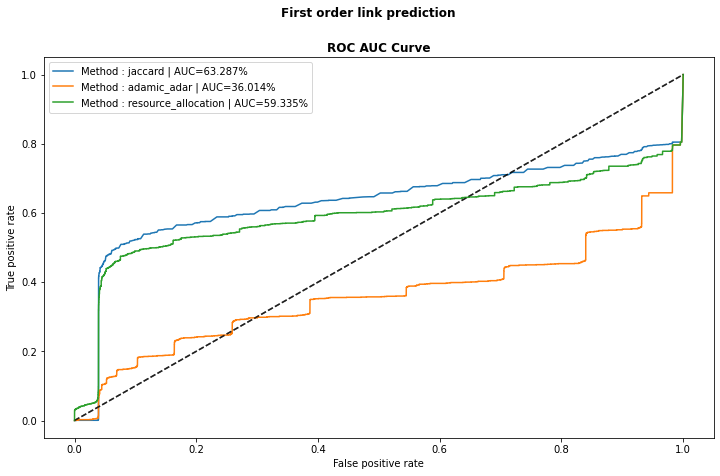

In [135]:
# Plots
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plt.suptitle('First order link prediction', weight='bold')
for k, v in res_auc.items():
    # Test AUC
    plt.plot(v['test_fpr'], v['test_tpr'], label=f"Method : {k} | AUC={100*v['test_auc']:.3f}%")
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC AUC Curve', weight='bold')
    plt.legend();

## Graph Neural Networks

The loss used is the **binary cross entropy**, which is defined by :
$$
H_{p}(q) = - \dfrac{1}{N}\sum_{i=1}^{N} y_i log(p(y_i)) + (1-y_{i}) log(1-p(y_{i}))
$$

In [520]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

    
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

def train(model, train_g, train_pos_g, train_neg_g, optimizer, nb_iter, predictor, verbose=True):
    
    history = defaultdict(list) # Useful for plots
    for epoch in range(nb_iter):
        
        # forward
        h = model(train_g, train_g.ndata['feat'].to(torch.float32))
        pos_score = predictor(train_pos_g, h)
        neg_score = predictor(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)
        
        #Save results
        history['train_loss'].append(loss.detach().numpy())
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if verbose:
            if epoch % 200 == 0:
                print(f'In epoch {epoch}, loss: {loss}')

    return h, history

def test(weights, test_pos_g, test_neg_g, return_all=False):
    
    history = {} # useful for plots
    
    with torch.no_grad():
        pos_score = pred(test_pos_g, weights)
        neg_score = pred(test_neg_g, weights)
        auc, fpr, tpr = compute_auc(pos_score, neg_score)
        #print('AUC', auc)
        
        # Save results
        history['test_auc'] = auc
        history['test_fpr'] = fpr
        history['test_tpr'] = tpr
        
        if return_all:
            return history, pos_score, neg_score
        else:
            return history

In [17]:
test_pos_g

Graph(num_nodes=403, num_edges=10529,
      ndata_schemes={'feat': Scheme(shape=(403,), dtype=torch.float64)}
      edata_schemes={'timestamp': Scheme(shape=(), dtype=torch.int64)})

### Graph convolution network

Conv layer, introduced in [Kipf et al](https://arxiv.org/pdf/1609.02907.pdf) work : 
$$
h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ji}}h_j^{(l)}W^{(l)})
$$

with $c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|}$ if `norm`='both', and classic average if `norm`='right'.

In [70]:
# build a 4-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, norm):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats, norm=norm)
        self.conv2 = GraphConv(h_feats, h_feats, norm=norm)
        self.conv3 = GraphConv(h_feats, h_feats, norm=norm)
        self.conv4 = GraphConv(h_feats, h_feats, norm=norm)

    def forward(self, g, in_feat):
        h = F.relu(self.conv1(g, in_feat))
        h = F.relu(self.conv2(g, h))
        h = F.relu(self.conv3(g, h))
        h = self.conv4(g, h)
        return h

In [83]:
%%time

# Agregators for GraphSAGE layer
norm_list = ['right', 'none', 'both']

# Parameters
nb_epochs = 1000
verbose = False
return_all = True

hist_tot = {}
for norm in norm_list:
    
    print(f'\nNormalization : {norm}\n------------------')
    
    # Initialize model
    model = GCN(train_g.ndata['feat'].shape[1], 16, norm)
    pred = DotPredictor()
    
    # Optimizer
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
    
    # -- Training --
    h, history_loss = train(model, train_g, train_pos_g, train_neg_g, optimizer, nb_epochs, verbose=False)
    hist_tot[norm] = {'train_loss': history_loss['train_loss']}
    
    # -- Test --
    history, test_pos_score, test_neg_score = test(h, test_pos_g, test_neg_g, return_all=return_all)
    hist_tot[norm].update({'test_auc': history['test_auc'], 
                          'test_fpr': history['test_fpr'],
                          'test_tpr': history['test_tpr']})


Normalization : right
------------------
AUC 0.639751663444807

Normalization : none
------------------
AUC 0.5258929389062332

Normalization : both
------------------
AUC 0.6101854791667587
CPU times: user 1min 36s, sys: 4.01 s, total: 1min 40s
Wall time: 1min 35s


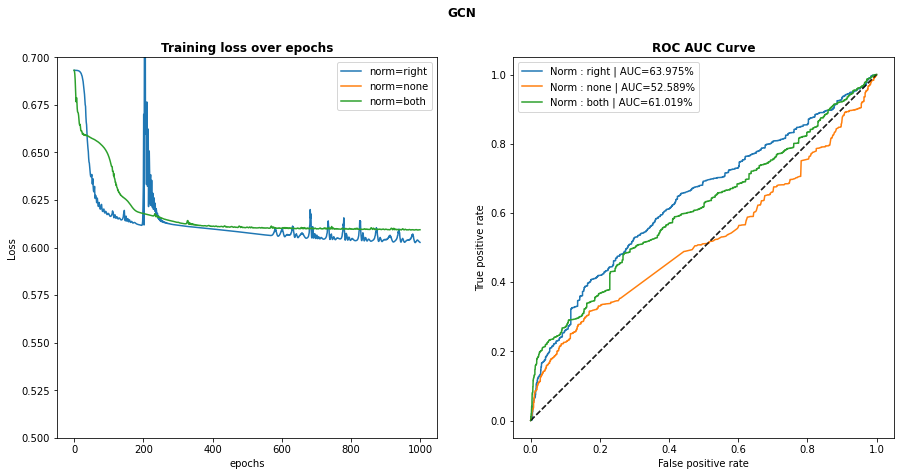

In [84]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle('GCN', weight='bold')

for norm, hist in hist_tot.items():
    
    # Training loss
    ax[0].plot(range(len(hist['train_loss'])), hist['train_loss'], 
             label=f"norm={norm}")
    ax[0].set_title('Training loss over epochs', weight='bold')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(0.5, 0.7)
    ax[0].legend()
    
    # Test AUC
    ax[1].plot(hist['test_fpr'], hist['test_tpr'], label=f"Norm : {norm} | AUC={100*hist['test_auc']:.3f}%")
    ax[1].plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
    ax[1].set_xlabel('False positive rate')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_title(f'ROC AUC Curve', weight='bold')
    ax[1].legend();

### GRAPH SAGE  

Source : https://docs.dgl.ai/en/0.6.x/api/python/nn.pytorch.html?highlight=graphsage#sageconv.  

GraphSAGE layer : 
$$
h_{\mathcal{N}(i)}^{(l+1)} = aggregate(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}) \\
h_{i}^{(l+1)} = \sigma \left(W \cdot \mathrm{concat}(h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right) \\
h_{i}^{(l+1)} = \mathrm{norm}(h_{i}^{l})
$$




In [85]:
from dgl.nn import SAGEConv

# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, agg):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, agg)
        self.conv2 = SAGEConv(h_feats, h_feats, agg)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [86]:
%%time

# Agregators for GraphSAGE layer
agg_list = ['mean', 'gcn', 'pool']

# # Epochs
nb_epochs = 1000
verbose = False

hist_tot = {}
for agg in agg_list:
    
    print(f'\nAggregator : {agg}\n------------------')
    
    # Initialize model
    model = GraphSAGE(train_g.ndata['feat'].shape[1], 16, agg)
    pred = DotPredictor()
    
    # Optimizer
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
    
    # -- Training --
    h, history_loss = train(model, train_g, train_pos_g, train_neg_g, optimizer, nb_epochs, verbose=False)
    hist_tot[agg] = {'train_loss': history_loss['train_loss']}
    
    # -- Test --
    history = test(h, test_pos_g, test_neg_g)
    hist_tot[agg].update({'test_auc': history['test_auc'], 
                          'test_fpr': history['test_fpr'],
                          'test_tpr': history['test_tpr']})


Aggregator : mean
------------------
AUC 0.7576961307829969

Aggregator : gcn
------------------
AUC 0.6962891816075131

Aggregator : pool
------------------
AUC 0.7555753382283106
CPU times: user 1min 51s, sys: 6.27 s, total: 1min 58s
Wall time: 1min 52s


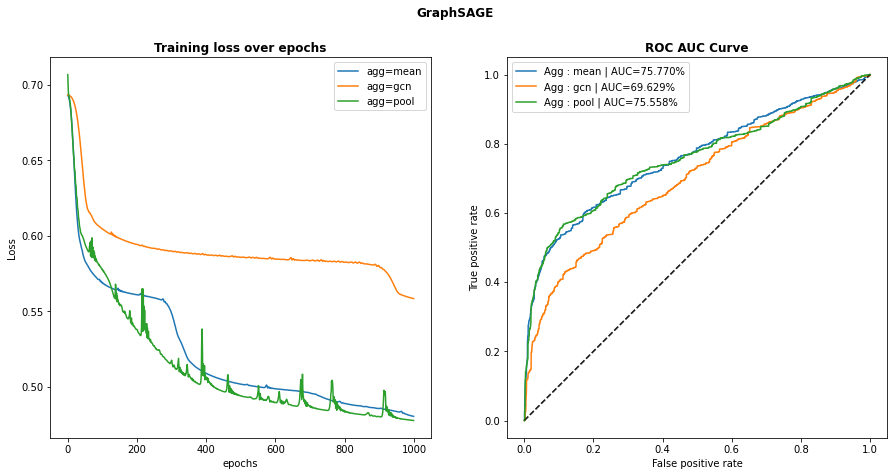

In [87]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle('GraphSAGE', weight='bold')

for agg, hist in hist_tot.items():
    
    # Training loss
    ax[0].plot(range(len(hist['train_loss'])), hist['train_loss'], 
             label=f"agg={agg}")
    ax[0].set_title('Training loss over epochs', weight='bold')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Test AUC
    ax[1].plot(hist['test_fpr'], hist['test_tpr'], label=f"Agg : {agg} | AUC={100*hist['test_auc']:.3f}%")
    ax[1].plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
    ax[1].set_xlabel('False positive rate')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_title(f'ROC AUC Curve', weight='bold')
    ax[1].legend();

**Custom GCN**  

Instead of aggregating a dynamic graph into a static one, and then perform embedding, we can first perform embedding on each timestamp (or on batches of time), and then aggregate these embeddings into a new one. These embeddings can be either 
- learned independently over time
- or learned using previous embedding at previous time to initalize a **memory cell**

A GNN application is computing node representation with the following scheme : aggregating and updating nodes features iteratively :
$$
h_{v}^{l+1} = \phi (h_{v}^{l}, f(h_{u}^{l} : u \in \mathcal{N}(v)))
$$
with $\phi$ and $f$ **injective functions** (indeed, two different sets of features in neighborhood should lead to two different representations after aggregation step).

For each batch (i.e subgraph of $\mathcal{G}$ for a specific period of time) :
$$
h_{\mathcal{N}(i)}^{(l+1)} = aggregate(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}) \\
h_{i}^{(l+1)} = memory_{i}^{t} = \sigma \left(W \cdot sum(h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right) \\
$$

From one batch to another, i.e from one timestep to another :
$$
h_{\mathcal{N}(i)}^{t+1} = aggregate(\{feat_{j}^{t+1}, \forall j \in \mathcal{N}(i) \}) \\
h_{i}^{t+1} = \sigma \left(W \cdot concat(memory_{i}^{t}, h_{\mathcal{N}(i)}^{t+1}) \right) \\
$$


Source : [How powerful are Graph Neural Networks](https://arxiv.org/pdf/1810.00826.pdf), [Relational Representation Learning for Dynamic (Knowledge) Graphs: A Survey](https://arxiv.org/pdf/1905.11485v1.pdf)

First, we need to divide a graph into batches, according to time.

In [13]:
def temporal_sampler(g, batch_size, timestep):
    ''' Returns a list of subgraph according to desired batch size. '''
    
    batches = []
    indexes = [] # returns list of index with 1 if batch-graph was returned, else 0
    
    batch_period = timestep * batch_size
    timerange = np.arange(int(g.edata['timestamp'].min()), int(g.edata['timestamp'].max()), batch_period)
    eids = np.arange(g.number_of_edges())
    
    for period in timerange:
    
        # Edges to remove
        rm_eids = eids[torch.logical_not(torch.logical_and(g.edata['timestamp'] >= period, 
                                                           g.edata['timestamp'] < (period + batch_period)))]
        
        batch_g = dgl.remove_edges(g, rm_eids) # also remove the feature attached to the edge
        
        # Later, use indexes to consider graph batch only if edges exist inside
        batches.append(batch_g)
        
        if batch_g.number_of_edges() != 0:
            indexes.append(True)
        else:
            indexes.append(False)
        
    return batches, indexes    

We can store the negative samples in a specific DataFrame.

In [324]:
%%time

# Build negative samples DataFrame
df_train_neg = pd.DataFrame(columns=['src', 'dest', 't'])

for neg_batch in train_neg_batches:
    for node_src, node_dest, t in zip(neg_batch.edges()[0], neg_batch.edges()[1], neg_batch.edata['timestamp']):
        df_train_neg.loc[len(df_train_neg.index)] = [int(node_src), int(node_dest), int(t)]
    
df_train_neg.head()

CPU times: user 1min 58s, sys: 2.03 s, total: 2min
Wall time: 2min 5s


,src,dest,t
0,317,260,32920
1,216,296,33080
2,193,69,33000
3,19,39,33100
4,213,13,33100


In [14]:
# Parameters
batch_size = 30 # numbers of time steps contained in one batch
timestep = 20

In [402]:
%%time 

# Build graph batches
train_batches, indexes_pos = temporal_sampler(train_g, batch_size, timestep)
train_neg_batches, _ = temporal_sampler(train_neg_g, batch_size, timestep)

# Filter graphs only for the period where a positive graph is computed
train_batches = np.array(train_batches)[indexes_pos]
train_neg_batches = np.array(train_neg_batches)[indexes_pos]

print(f'# of pos train batch-graph : {len(train_batches)}')
print(f'# of neg train batch-graph : {len(train_neg_batches)}')

# of pos train batch-graph : 95
# of neg train batch-graph : 95
CPU times: user 936 ms, sys: 311 ms, total: 1.25 s
Wall time: 1.24 s


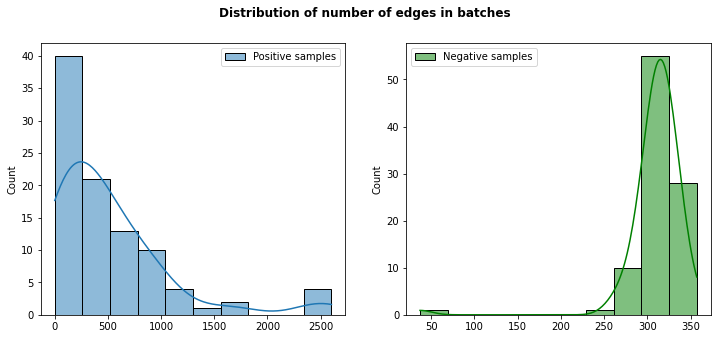

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Distribution of number of edges in batches', weight='bold')
sns.histplot([batch.number_of_edges() for batch in train_batches], kde=True, ax=ax[0], label='Positive samples', bins=10)
sns.histplot([batch.number_of_edges() for batch in train_neg_batches], kde=True, ax=ax[1], label='Negative samples', color='g', bins=10)
ax[0].legend();ax[1].legend();

**Reduce negative sample batch size**

In [17]:
pos_batch_sizes = [batch.number_of_edges() for batch in train_batches]
neg_eids = [np.random.choice(neg_g.edges(form='eid'), neg_g.number_of_edges() - pos_size) if neg_g.number_of_edges() > pos_size else [0] for neg_g, pos_size in zip(train_neg_batches, pos_batch_sizes)]
train_neg_batches_reduced = [dgl.remove_edges(neg_g, neg_eid) for neg_g, neg_eid in zip(train_neg_batches, neg_eids)]

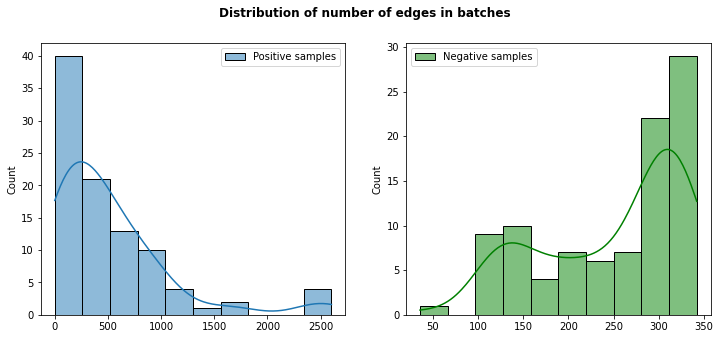

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Distribution of number of edges in batches', weight='bold')
sns.histplot([batch.number_of_edges() for batch in train_batches], kde=True, ax=ax[0], label='Positive samples', bins=10)
sns.histplot([batch.number_of_edges() for batch in train_neg_batches_reduced], kde=True, ax=ax[1], label='Negative samples', color='g', bins=10)
ax[0].legend();ax[1].legend();

We build a **memory** feature for each batch-graph. The memory is initialized to 0.

In [898]:
def init_memory(g):
    g.ndata['mem'] = torch.zeros(g.number_of_nodes(), 1)

In [899]:
# Initialize memory node feature for each batch-graph
for train_batch_g, train_neg_batch_g in zip(train_batches, train_neg_batches):
    init_memory(train_batch_g)
    init_memory(train_neg_batch_g)

The **feature** tensor for each node is computed for every batch-graph. Indeed, as node feature depends on time, it is necessary to recompute this information for every subgraph.

In [20]:
def compute_batch_feature(g, timerange, add_self_edge=True):
    
    # Add edges between node and itself
    if add_self_edge:
        g.add_edges(g.nodes(), g.nodes())
    
    src, dest = g.edges()
    adj = np.zeros((g.number_of_nodes(), g.number_of_nodes()))
    for src_val, dest_val in zip(src, dest):
        adj[src_val, dest_val] += 1
    
    norm_mat = np.eye(adj.shape[0]) * (1 / len(timerange))
    norm_adj = adj.dot(norm_mat)
    
    return norm_adj

In [30]:
%%time

for train_batch_g in train_batches:
    train_batch_timerange = np.arange(int(train_batch_g.edata['timestamp'].min()), int(train_batch_g.edata['timestamp'].max()) + 20, 20)

    # Compute features 
    if train_batch_timerange[0] != 0:
        train_batch_feat = compute_batch_feature(train_batch_g, train_batch_timerange, add_self_edge=False) # self edges already added
        train_batch_g.ndata['feat'] = torch.Tensor(train_batch_feat)
        
for train_neg_batch_g in train_neg_batches_reduced:
    train_neg_batch_timerange = np.arange(int(train_neg_batch_g.edata['timestamp'].min()), int(train_neg_batch_g.edata['timestamp'].max()) + 20, 20)

    # Compute features 
    if train_neg_batch_timerange[0] != 0:
        train_neg_batch_feat = compute_batch_feature(train_neg_batch_g, train_neg_batch_timerange, add_self_edge=False) # self edges already added
        train_neg_batch_g.ndata['feat'] = torch.Tensor(train_neg_batch_feat)

CPU times: user 3.61 s, sys: 312 ms, total: 3.93 s
Wall time: 2.11 s


**Normalize adjacency/features**  

Using the formula :
$$
\hat{A} = D^{-1/2}AD^{-1/2}
$$

In [78]:
def normalize_adj(A):
    
    A_arr = A.numpy()

    # Compute degrees of adjacency matrix
    deg = A_arr.dot(np.ones(A_arr.shape[1]))
    #D_norm = np.diag(np.sqrt(np.reciprocal(deg, where=[deg!=0])))
    D_norm = np.diag(np.sqrt(deg))
    
    # Normalize adjacency matrix
    A_norm = D_norm.dot(A_arr).dot(D_norm)
    
    return A_norm

In [79]:
# Normalize features for training batches
for train_batch_g, train_neg_batch_g in zip(train_batches, train_neg_batches_reduced):
    
    # positive samples
    feat_norm = normalize_adj(train_batch_g.ndata['feat'])
    train_batch_g.ndata['feat_norm'] = torch.from_numpy(feat_norm)
    
    # negative samples
    feat_neg_norm = normalize_adj(train_neg_batch_g.ndata['feat'])
    train_neg_batch_g.ndata['feat_norm'] = torch.from_numpy(feat_neg_norm)

The messaging process is defined using the memory information in addition to the feature information :  
- embedding is computed for nodes in the first batch-graph  
- memory of nodes is updated with the node embedding values  
- for the next batch-graph, embedding is computed using both previous batch memory and current batch features

In [814]:
def message_func(edges):
    return {'m': edges.src['h']}

def reduce_concat_func(nodes):
    print(nodes.data['mem'].shape)
    print(torch.sum(nodes.mailbox['m'], dim=1).shape)
    return {'mem': torch.cat((nodes.data['mem'], torch.sum(nodes.mailbox['m'], dim=1)), dim=1)}

def reduce_sum_func(nodes):
    #print(f"   previous memory = {nodes.data['mem'].sum()} - neigh features : {torch.sum(nodes.mailbox['m'], dim=1).sum()}")
    #return {'mem': F.normalize(torch.sum(nodes.data['mem'], dim=1), dim=0).unsqueeze(dim=1) + torch.sum(nodes.mailbox['m'], dim=1)}
    return {'h_N': torch.mean(nodes.mailbox['m'], dim=1)}

In [103]:
class GCNCustomLayer(nn.Module):
    def __init__(self, features_in, features_out):
        super().__init__()
        self.linear_mem = nn.Linear(features_in + features_out, features_out)
        self.linear = nn.Linear(features_in, features_out)
        
    def forward(self, g, h, memory=None):
        with g.local_scope():
            if memory is not None:
                g.ndata['mem'] = memory
            g.ndata['h'] = h
            g.update_all(message_func=fn.copy_u('h', 'm'), reduce_func=fn.sum('m', 'h_N'))
            h_N = g.ndata['h_N']
            if memory is not None:
                h = torch.cat([memory, h_N], dim=1)
                h = F.normalize(h, dim=1)
                return self.linear_mem(h)
            else:
                #h_mem = torch.cat([h, h_N], dim=1)
                h_mem = h + h_N
                h_mem = F.normalize(h_mem, dim=1)
                return self.linear(h_mem)
            
class CustomModel(nn.Module):
    def __init__(self, in_feats, h_feats):
        super().__init__()
        self.layer1 = GCNCustomLayer(in_feats, h_feats)
        self.layer2 = GCNCustomLayer(h_feats, h_feats)
    
    # For the 1st layer of the model, the memory from the previous batch-graph is used
    def forward(self, g, in_feat, memory):
        h = F.relu(self.layer1(g, in_feat, memory))
        h = self.layer2(g, h)
        return h    
    
class CustomDotPredictor(nn.Module):
    def forward(self, g, mem):
        with g.local_scope():
            g.ndata['h'] = mem
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'].squeeze(dim=1)

In [1160]:
%%time

embedding_dimension = 16 
history = defaultdict(list)

# Model initialization
model = CustomModel(train_batches[0].ndata['feat'].shape[1], embedding_dimension)
pred = CustomDotPredictor()
optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.0001)
    
# Initialize memory of model
prev_memory = torch.zeros(train_pos_g.number_of_nodes(), embedding_dimension, requires_grad=False).data.numpy()

# -- Training --
nb_epoch = 1000
for epoch in range(nb_epoch):
    # Iterates over batches (except the first one which contains only self applied edges)
        
    for idx, (batch_pos_g, batch_neg_g) in enumerate(zip(train_batches[1:], train_neg_batches_reduced[1:])):

        #print(f'Batch n°:{idx} - # nodes : {batch_pos_g.number_of_nodes()} - # edges : {batch_pos_g.number_of_edges()}')
        
        # Forward
        mem = model(batch_pos_g, batch_pos_g.ndata['feat'].to(torch.float32), torch.from_numpy(prev_memory))
        history['embedding'].append(mem)
        prev_memory = mem.data.numpy()
        pos_score = pred(batch_pos_g, mem)
        neg_score = pred(batch_neg_g, mem)
        loss = compute_loss(pos_score, neg_score)

        # Save results
        history['train_loss'].append(loss.detach().numpy())

        # Backward
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward()
        optimizer.step()

        #if idx == 150:
        #    break
        
    if epoch % 100 == 0:
        print(f'Training loss: {loss}')

Training loss: 0.5635179281234741
Training loss: 0.31145086884498596
Training loss: 0.2789129912853241
Training loss: 0.2584797441959381
Training loss: 0.25591805577278137
Training loss: 0.24623866379261017
Training loss: 0.2362549901008606
Training loss: 0.23723511397838593
Training loss: 0.2184973508119583
Training loss: 0.21888045966625214
CPU times: user 1h 5min 3s, sys: 16min 46s, total: 1h 21min 50s
Wall time: 1h 50min 45s


**Delta in embeddings**

In [1161]:
deltas_emb = [np.linalg.norm(prev.detach().numpy() - curr.detach().numpy(), ord='fro') for prev, curr in zip(history['embedding'][:-1], history['embedding'][1:])]

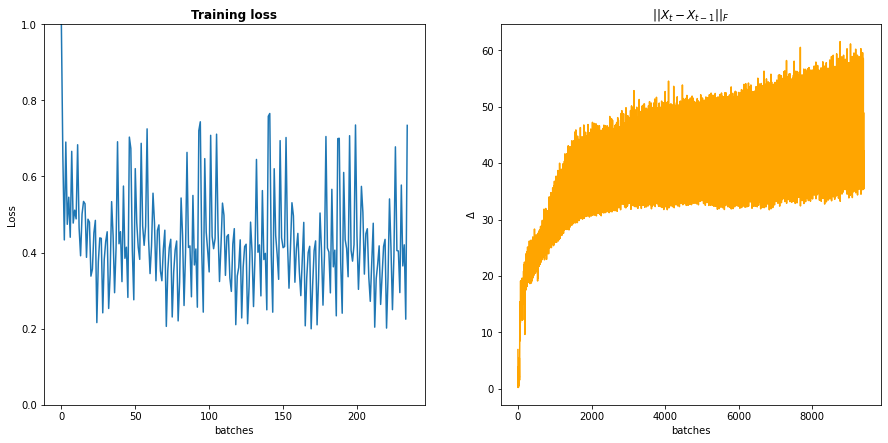

In [1170]:
a = [float(x) for x in history['train_loss'][::400]]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(range(len(a)), a)
ax[0].set_ylim(0, 1)
ax[0].set_title('Training loss', weight='bold')
ax[0].set_xlabel('batches')
ax[0].set_ylabel('Loss')
ax[1].plot(range(len(deltas_emb[::10])), deltas_emb[::10], color='orange')
ax[1].set_title('$||X_{t} - X_{t-1}||_{F}$', weight='bold')
ax[1].set_xlabel('batches')
ax[1].set_ylabel('$\Delta$');

In [1173]:
# -- Test --
history_custom, test_pos_score, test_neg_score = test(mem, test_pos_g, test_neg_g, return_all=return_all)
history_custom['custom'] = {'test_auc': history_custom['test_auc'], 
                      'test_fpr': history_custom['test_fpr'],
                      'test_tpr': history_custom['test_tpr']}

AUC 0.6285581992810829


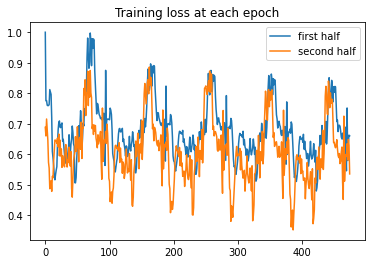

In [1180]:
cut = int(len(history['train_loss'][:950])/2)
first_epoch = [float(loss) for loss in history['train_loss'][:950]][:cut]
second_epoch = [float(loss) for loss in history['train_loss'][:950]][cut:]

plt.plot(range(len(first_epoch)), first_epoch, label='first half')
plt.plot(range(len(second_epoch)), second_epoch, label='second half')
plt.title('Training loss at each epoch')
plt.legend();

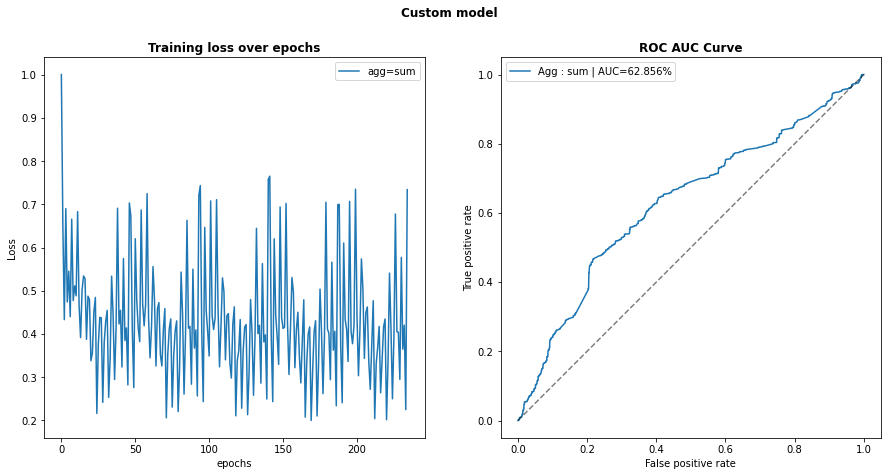

In [1175]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle('Custom model', weight='bold')
   
# Training loss
ax[0].plot(range(len(a)), a, 
         label=f"agg=sum")
ax[0].set_title('Training loss over epochs', weight='bold')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Test AUC
ax[1].plot(history_custom.get('custom')['test_fpr'], history_custom.get('custom')['test_tpr'], label=f"Agg : sum | AUC={100*history_custom.get('custom')['test_auc']:.3f}%")
ax[1].plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title(f'ROC AUC Curve', weight='bold')
ax[1].legend();

**Using average embedding**  

Following [Kazemi et al](https://arxiv.org/pdf/1905.11485v1.pdf), two different methods are used to average embeddings across time :
* uniform average on each embedding $X$ at time $t$
$$
\tilde{X}_T = \dfrac{1}{T} \sum_{t=1}^{T} X_t
$$
* Exponential decay for older embeddings
$$
\tilde{X}_T = \sum_{t=1}^{T} e^{-\theta(T-t)}X_t
$$
with $\theta$ a parameter to choose

In [134]:
%%time

embedding_dimension = 16 
history = defaultdict(list)

# Model initialization
model = CustomModel(train_batches[0].ndata['feat'].shape[1], embedding_dimension)
pred = CustomDotPredictor()
optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.0001)
    
# Initialize memory of model
prev_memory = torch.zeros(train_pos_g.number_of_nodes(), embedding_dimension, requires_grad=False).data.numpy()

# -- Training --
nb_epoch = 500
for epoch in range(nb_epoch):
    # Iterates over batches (except the first one which contains only self applied edges)
        
    for idx, (batch_pos_g, batch_neg_g) in enumerate(zip(train_batches[1:], train_neg_batches_reduced[1:])):

        #print(f'Batch n°:{idx} - # nodes : {batch_pos_g.number_of_nodes()} - # edges : {batch_pos_g.number_of_edges()}')
        
        # Forward
        mem = model(batch_pos_g, batch_pos_g.ndata['feat'].to(torch.float32), torch.from_numpy(prev_memory))
        history['embedding'].append(mem)
        prev_memory = mem.data.numpy()
        pos_score = pred(batch_pos_g, mem)
        neg_score = pred(batch_neg_g, mem)
        loss = compute_loss(pos_score, neg_score)

        # Save results
        history['train_loss'].append(loss.detach().numpy())

        # Backward
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward()
        optimizer.step()

        #if idx == 150:
        #    break
        
    if epoch % 100 == 0:
        print(f'Training loss: {loss}')

Training loss: 0.5721059441566467
Training loss: 0.2973833382129669
Training loss: 0.24490338563919067
Training loss: 0.21529348194599152
Training loss: 0.21575897932052612
CPU times: user 6min 8s, sys: 20.5 s, total: 6min 29s
Wall time: 6min 13s


In [135]:
def plot_auc(res, ax, title, label=None):
    ax.plot(res['test_fpr'], res['test_tpr'], label=f"Agg : sum | AUC={100*res['test_auc']:.3f}% {label}")
    ax.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(f'ROC AUC Curve - {title}', weight='bold')
    ax.legend();

AUC 0.6665742015632152
AUC 0.6542202419359414
AUC 0.6444462517314995
AUC 0.6424481205958071


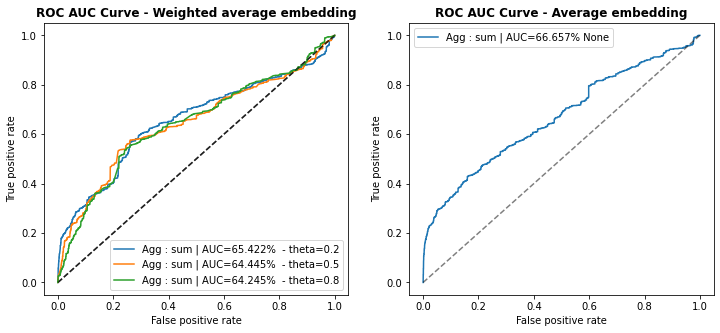

In [136]:
# Average embedding
res = torch.zeros(history['embedding'][0].shape)
for emb in history['embedding']:
    res += emb
res = res/len(history['embedding'])

# Average embedding with weight decay
thetas = [0.2, 0.5, 0.8]
res_w_tot = []
for theta in thetas:
    res_w = torch.zeros(history['embedding'][0].shape)
    for idx, emb in enumerate(history['embedding']):
        res_w += np.exp(-theta * (len(history['embedding']) - idx)) * emb
        #res_w = res_w / len(history['embedding'])
    res_w_tot.append(res_w)

# Test AUC
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# -- Test --
history_custom, test_pos_score, test_neg_score = test(res, test_pos_g, test_neg_g, return_all=True)
history_custom['custom_avg'] = {'test_auc': history_custom['test_auc'], 
                      'test_fpr': history_custom['test_fpr'],
                      'test_tpr': history_custom['test_tpr']}
plot_auc(history_custom.get('custom_avg'), ax=ax[1], title='Average embedding')

# -- Test weighted --
for idx, theta in enumerate(thetas):
    history_custom_w, test_pos_score, test_neg_score = test(res_w_tot[idx], test_pos_g, test_neg_g, return_all=True)
    history_custom_w['custom_avg'] = {'test_auc': history_custom_w['test_auc'], 
                          'test_fpr': history_custom_w['test_fpr'],
                          'test_tpr': history_custom_w['test_tpr']}
    plot_auc(history_custom_w.get('custom_avg'), ax=ax[0], title='Weighted average embedding', label=f' - theta={theta}')

**IDEAS**  

* Use MLP instead of 1 linear layer for injective function ?
* not using memory cell but rather aggregating embeddings with **weight decay** (according to time) ?
* Add **smoothness constraint** to the loss : minimize distance between 2 consecutive embeddings

#### Adding smoothness constraint  

A **smoothness constraint** is added to the loss. The goal is to force the model not to add brutal changes in nodes embeddings between two consecutives snapshots (or batches of time). 

* This constraint can be computed using the Froebinus norm ; for all $v \in V^{t}$ :
$$
||h^{t}_{v} - h^{t-1}_{v}||_{F}
$$
should be small (with $h_{v}^{t}$ the embedding of node $v$ at time $t$, and $||.||_{F}$ the Froebinus norm) 

* or using **average cosine similarity**, for each node embedding, the cosine similarity is :
$$
k(x, y) = \dfrac{<x, y>}{||x||.||y||}
$$
The goal is then to minimize $1 - k^2$, in order to penalize embeddings that are not similar between two snapshots.

In [1287]:
%%time

embedding_dimension = 16 
history = defaultdict(list)

# Model initialization
model = CustomModel(train_batches[0].ndata['feat'].shape[1], embedding_dimension)
pred = CustomDotPredictor()
optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.0001)
    
# Initialize memory of model
prev_memory = torch.zeros(train_pos_g.number_of_nodes(), embedding_dimension, requires_grad=False).data.numpy()

# -- Training --
nb_epoch = 10
smooth, loss_only = [], []
for epoch in range(nb_epoch):
    # Iterates over batches (except the first one which contains only self applied edges)
    for idx, (batch_pos_g, batch_neg_g) in enumerate(zip(train_batches[1:], train_neg_batches_reduced[1:])):
        
        # Forward
        mem = model(batch_pos_g, batch_pos_g.ndata['feat'].to(torch.float32), torch.from_numpy(prev_memory))
        history['embedding'].append(mem)
        pos_score = pred(batch_pos_g, mem)
        neg_score = pred(batch_neg_g, mem)
        
        # Smoothness constaint between current memory and previous memory
        #smoothness_constraint = np.linalg.norm(mem.detach().numpy() - prev_memory, ord='fro')
        smoothness_constraint = cosine_similarity(mem.detach().numpy(), prev_memory).mean()
        
        loss = compute_loss(pos_score, neg_score) + (1 - smoothness_constraint**2)
        smooth.append(1 - smoothness_constraint**2)
        loss_only.append(compute_loss(pos_score, neg_score).detach().numpy())

        # Update memory
        prev_memory = mem.detach().numpy()
        
        # Save results
        history['train_loss'].append(loss.detach().numpy())

        # Backward
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward()
        optimizer.step()
        
        #if idx > 50:
        #    break
        
    if epoch % 2 == 0:
        print(f'Training loss: {loss}')

Training loss: 0.6353045701980591
Training loss: 0.769008457660675
Training loss: 1.0438764095306396
Training loss: 1.3012969493865967
Training loss: 1.3586026430130005
CPU times: user 1min 22s, sys: 12 s, total: 1min 34s
Wall time: 1min 24s


In [85]:
def plot_history_loss(history, ax):
    ax.plot(range(len(history)), history)
    #ax.set_ylim(0, 1)
    ax.set_title('Training loss', weight='bold')
    ax.set_xlabel('batches')
    ax.set_ylabel('Loss');
    
def plot_delta_emb(delta_emb, ax):
    ax.plot(range(len(delta_emb)), delta_emb, color='orange')
    ax.set_title('$||X_{t} - X_{t-1}||_{F}$', weight='bold')
    ax.set_xlabel('batches')
    ax.set_ylabel('$\Delta$');

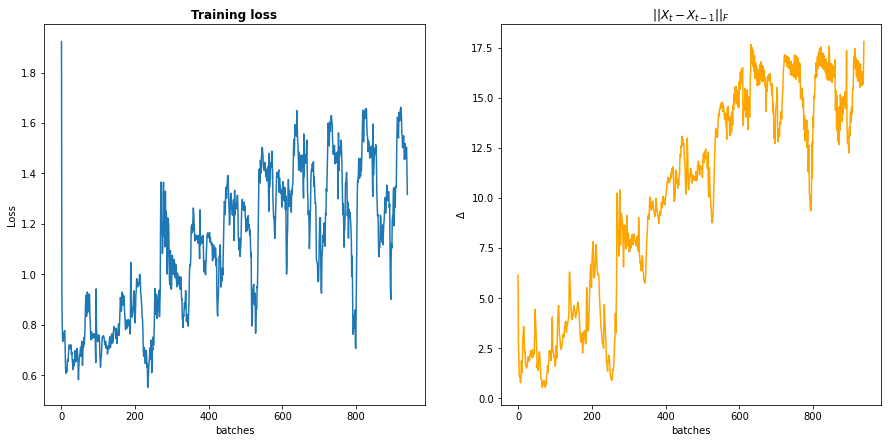

In [1251]:
# Training loss
hist_train_loss = [float(x) for x in history['train_loss']]
# Embedding variations  
deltas_emb = [np.linalg.norm(prev.detach().numpy() - curr.detach().numpy(), ord='fro') for prev, curr in zip(history['embedding'][:-1], history['embedding'][1:])]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plot_history_loss(hist_train_loss, ax[0])
plot_delta_emb(deltas_emb, ax[1])

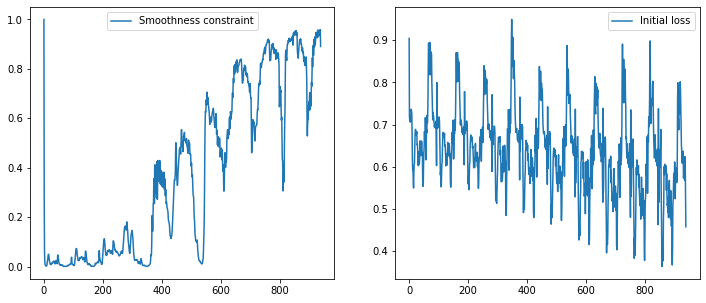

In [1288]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(len(smooth)), smooth, label='Smoothness constraint')
ax[1].plot(range(len(loss_only)), loss_only, label='Initial loss')
ax[0].legend()
ax[1].legend();

### GCN stacking

The goal is to model embedding of node $u$ at time $t$ as a combination of Graph neural networks, using node's embedding at previous timestep as well as neighbor's embedding at current timestep :  

$$
h^{t}_u = z(f(h_u^{t-1}), g(h_v^{t} : v \in \mathcal{N}_{u}^t))
$$

with $h$ the embedding to be learned, $f$ and $g$ graph neural networks using message passing process, and $z$ a function to determine (weighted sum, average).

In [80]:
class MemoryLayer(nn.Module):
    def __init__(self, features_in, features_out):
        super().__init__()
        self.linear = nn.Linear(features_in, features_out)
        
    def forward(self, g, memory):
        with g.local_scope():
            g.ndata['mem'] = memory
            #print(f'     in layer - Memory : {memory.shape} - {memory.sum()}')
            g.update_all(message_func=fn.copy_u('mem', 'm'), reduce_func=fn.sum('m', 'mem_N'))
            mem_N = g.ndata['mem_N']
            #print(f'     in layer - Neighbors memory {mem_N.shape} - {mem_N.sum()}')
            mem_N = F.normalize(mem_N, dim=1)
            #print(f'     in layer - Norm Neighbors memory {mem_N.shape} - {mem_N.sum()}')
            return self.linear(mem_N)
            
class MemoryModel(nn.Module):
    def __init__(self, in_feats, h_feats):
        super().__init__()
        self.layer1 = MemoryLayer(h_feats, h_feats)
        self.layer2 = MemoryLayer(h_feats, h_feats)
    
    def forward(self, g, memory):
        #print(f'Before layer 1 - {memory.shape} - {memory.sum()}')
        h = F.relu(self.layer1(g, memory))
        #print(f'After layer 1 - {h.shape} - {h.sum()}')
        h = self.layer2(g, h)
        #print(f'After layer 2 - {h.shape} - {h.sum()}')
        return h   
    
class GCNLayer(nn.Module):
    def __init__(self, features_in, features_out):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(features_in, features_out)
        
    def forward(self, g, features):
        with g.local_scope():
            g.ndata['h'] = features
            g.update_all(message_func=fn.copy_u('h', 'm'), reduce_func=fn.sum('m', 'h_N'))
            h_N = F.normalize(g.ndata['h_N'], dim=1)
            return self.linear(h_N)
        
class GCNModel(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCNModel, self).__init__()
        self.layer1 = GCNLayer(in_feats, h_feats)
        self.layer2 = GCNLayer(h_feats, h_feats)
        
    def forward(self, g, features):
        h = F.relu(self.layer1(g, features))
        h = self.layer2(g, h)
        return h    
    
class CustomDotPredictor(nn.Module):
    def forward(self, g, mem):
        with g.local_scope():
            g.ndata['h'] = mem
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'].squeeze(dim=1)

**Using Normalized adjacency**

In [131]:
%%time

embedding_dimension = 16 
history = defaultdict(list)

# Model initialization
gcn_model = GCNModel(train_batches[0].ndata['feat_norm'].shape[1], embedding_dimension)
pred = CustomDotPredictor()
 
# Initialize memory of model
prev_memory = np.zeros((train_pos_g.number_of_nodes(), embedding_dimension))
mem_model = MemoryModel(prev_memory.shape[0], embedding_dimension)

# Optimizer
optimizer_gcn = torch.optim.Adam(itertools.chain(gcn_model.parameters(), mem_model.parameters()), lr=0.0001)

visited_nodes = set()
# -- Training --
nb_epoch = 100
for epoch in range(nb_epoch):
    # Iterates over batches (except the first one which contains only self applied edges)
    for idx, (batch_pos_g, batch_neg_g) in enumerate(zip(train_batches[1:], train_neg_batches_reduced[1:])):
        #print(f'---- Batch N°{idx} ----')
        # Forward
        emb_N = gcn_model(batch_pos_g, batch_pos_g.ndata['feat_norm'].to(torch.float32))
        curr_memory = mem_model(batch_pos_g, torch.from_numpy(prev_memory).to(torch.float32))
        emb_tot = (emb_N + curr_memory)/2
        
        # Tracks visited nodes (i.e nodes that are source or destination of an edge)
        # For the others nodes, embedding is forced to 0
        #visited_nodes.update(set(batch_pos_g.edges()[0].numpy()).union(set(batch_pos_g.edges()[1].numpy())))
        #for node in range(emb_tot.shape[0]):
        #    if node not in visited_nodes:
        #        emb_tot[node, :] = 0
        
        pos_score = pred(batch_pos_g, emb_tot)
        neg_score = pred(batch_neg_g, emb_tot)
        loss = compute_loss(pos_score, neg_score)
        
        # Update memory
        prev_memory = emb_N.detach().numpy()
        
        # Save results
        history['train_loss'].append(loss.detach().numpy())
        history['embedding'].append(emb_tot)

        # Backward
        optimizer_gcn.zero_grad() # zero the parameter gradients
        loss.backward()
        optimizer_gcn.step()
        
        #if idx > 50:
        #    break
    if epoch % 10 == 0:
        print(f'Training loss : {loss}')

Training loss : 0.591590166091919
Training loss : 0.3593306243419647
Training loss : 0.3477235734462738
Training loss : 0.35004085302352905
Training loss : 0.3466382920742035
Training loss : 0.3418113887310028
Training loss : 0.3376181721687317
Training loss : 0.33449286222457886
Training loss : 0.33198511600494385
Training loss : 0.32956844568252563
CPU times: user 1min 37s, sys: 5.4 s, total: 1min 42s
Wall time: 1min 39s


AUC 0.5367849210608195


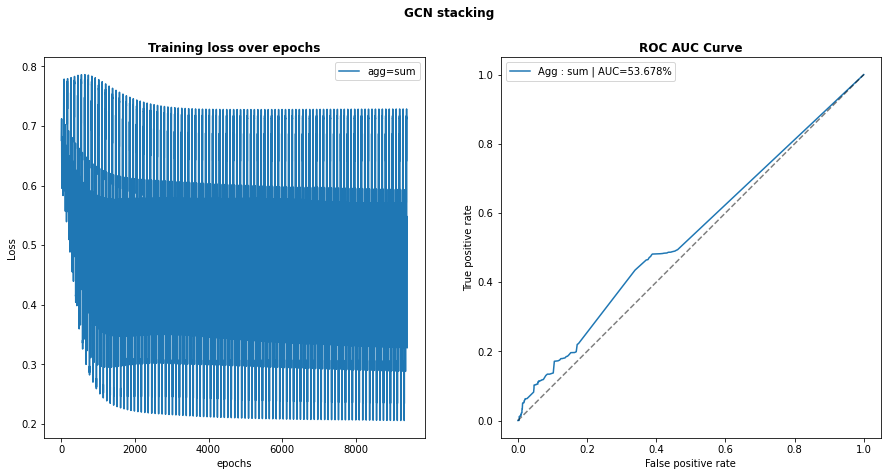

In [132]:
# -- Test --
history_stack, test_pos_score, test_neg_score = test(emb_tot, test_pos_g, test_neg_g, return_all=True)
history_stack['stack'] = {'test_auc': history_stack['test_auc'], 
                      'test_fpr': history_stack['test_fpr'],
                      'test_tpr': history_stack['test_tpr']}

# Training loss
hist_train_loss = [float(x) for x in history['train_loss']]

# Plots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle('GCN stacking', weight='bold')
   
# Training loss
ax[0].plot(range(len(hist_train_loss)), hist_train_loss, label=f"agg=sum")
ax[0].set_title('Training loss over epochs', weight='bold')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Test AUC
ax[1].plot(history_stack.get('stack')['test_fpr'], history_stack.get('stack')['test_tpr'], label=f"Agg : sum | AUC={100*history_stack.get('stack')['test_auc']:.3f}%")
ax[1].plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title(f'ROC AUC Curve', weight='bold')
ax[1].legend();

**Using average embedding**

AUC 0.6858791724227711
AUC 0.6667519846073025
AUC 0.6373999895958717
AUC 0.6157406991049177


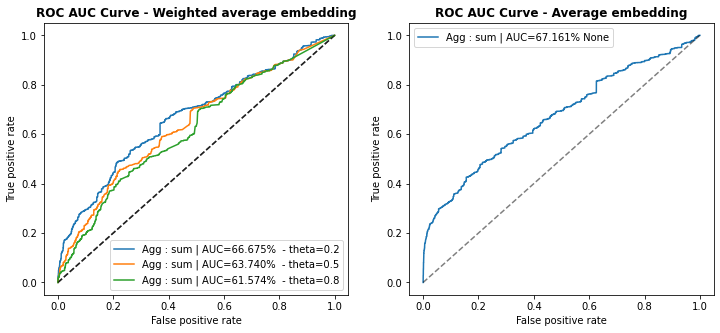

In [133]:
# Average embedding
res = torch.zeros(history['embedding'][0].shape)
for emb in history['embedding']:
    res += emb
res = res/len(history['embedding'])

# Average embedding with weight decay
thetas = [0.2, 0.5, 0.8]
res_w_tot = []
for theta in thetas:
    res_w = torch.zeros(history['embedding'][0].shape)
    for idx, emb in enumerate(history['embedding']):
        res_w += np.exp(-theta * (len(history['embedding']) - idx)) * emb
        #res_w = res_w / len(history['embedding'])
    res_w_tot.append(res_w)

# Test AUC
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# -- Test --
history_stack, test_pos_score, test_neg_score = test(res, test_pos_g, test_neg_g, return_all=True)
history_stack['custom_avg'] = {'test_auc': history_stack['test_auc'], 
                      'test_fpr': history_stack['test_fpr'],
                      'test_tpr': history_stack['test_tpr']}
plot_auc(history_custom.get('custom_avg'), ax=ax[1], title='Average embedding')

# -- Test weighted --
for idx, theta in enumerate(thetas):
    history_stack_w, test_pos_score, test_neg_score = test(res_w_tot[idx], test_pos_g, test_neg_g, return_all=True)
    history_stack_w['custom_avg'] = {'test_auc': history_stack_w['test_auc'], 
                          'test_fpr': history_stack_w['test_fpr'],
                          'test_tpr': history_stack_w['test_tpr']}
    plot_auc(history_stack_w.get('custom_avg'), ax=ax[0], title='Weighted average embedding', label=f' - theta={theta}')

## Discrete Time Fourier Transform

Using [DYNAMIC GRAPH REPRESENTATION LEARNING WITH
FOURIER TEMPORAL STATE EMBEDDING](https://openreview.net/pdf?id=pBDwTjmdDo), we use Discrete Time Fourier Transform (DTFT) to model the existence of edges in a graph over time. For this purpose, we consider edges between two nodes over time as a discrete signal and then use the length of the signal (i.e size of batch) to compute the frequency response :  
$$
A_k = \sum_{m=0}^{T-1} a_{m} e^{-2 \pi i \frac{mk}{N}},  k=0, ..., N-1
$$
with $a$ the time-domain signal, $T$ the length of the timerange (here it corresponds to the batchsize) and $N$ the size of the frequency-domain embedding (here we consider $N=T$).  
The **amplitude** of the spectrum is $|A|$.

In [410]:
def DTFT(g, timerange, df, N, add_self_edge=False):
    
    # Add edges between node and itself
    if add_self_edge:
        g.add_edges(g.nodes(), g.nodes())
    
    # Tensor initialization
    adj = torch.zeros(len(g.nodes()), len(g.nodes()), len(timerange))
    fourier_feat = torch.zeros(len(g.nodes()), len(g.nodes()), N)
    T_ = len(timerange)
    
    # For every pair of nodes, create a tensor with size len(timerange)
    # containing 1 if node exists (i.e if node is part of an edge) at time t
    # This tensor corresponds to the Discrete time serie
    for node_src, node_dest, time in zip(df['src'], df['dest'], df['t']):
        time_index = list(timerange).index(time)
        adj[node_src, node_dest, time_index] = 1
        
    # For each entry in the Discrete time serie, compute N samples (with N=T) at interval 2*pi / N
    # within a single period (source : https://openreview.net/pdf?id=pBDwTjmdDo)
    for node_src in range(adj.shape[0]):
        for node_dest in range(adj.shape[1]):            
            X_temp = np.fft.fft(adj[node_src, node_dest, :], N)
            # When the input a is a time-domain signal and A = fft(a), np.abs(A) is its amplitude spectrum
            # Source : https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft
            fourier_feat[node_src, node_dest, :] = torch.from_numpy(np.abs(X_temp))
                
    #        for time in range(adj.shape[2]):
    #            fourier_feat[node_src, node_dest, time] = \
    #                np.sum([adj[node_src, node_dest, t_n] * np.exp(-2j*np.pi*(time*t_n)/T_) for t_n in range(fourier_feat.shape[2])])
    
    return fourier_feat

In [266]:
%%time

# Training dataframe
max_train_time = int(train_pos_g.edata['timestamp'].max())
df_train = df_preproc[df_preproc['t']<=max_train_time]

# Compute features
train_timerange = np.arange(int(train_pos_g.edata['timestamp'].min()), int(train_pos_g.edata['timestamp'].max()) + 20, 20)
fourier_feat = DTFT(train_pos_g, train_timerange, df_train, add_self_edge=False)

CPU times: user 3min 25s, sys: 14.9 s, total: 3min 40s
Wall time: 3min 50s


**Plots**

# of interactions for nodes (36, 144)  :  13
# of interactions for nodes (0, 24) :  17
# of interactions for nodes (0, 14) :  6


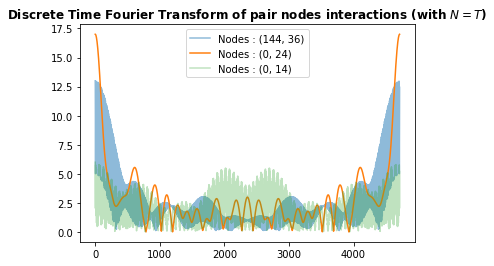

In [302]:
# Count number of interactions over time for pair of nodes
print('# of interactions for nodes (36, 144)  : ', df_preproc[(df_preproc['src']==144) & (df_preproc['dest']==36)].count()[0])
#print('# of interactions for nodes (159, 37) : ', df_preproc[(df_preproc['src']==159) & (df_preproc['dest']==37)].count()[0])
print('# of interactions for nodes (0, 24) : ', df_preproc[(df_preproc['src']==0) & (df_preproc['dest']==24)].count()[0])
print('# of interactions for nodes (0, 14) : ', df_preproc[(df_preproc['src']==0) & (df_preproc['dest']==14)].count()[0])

# Example of DTFT for a few pair of nodes
plt.plot(range(len(fourier_feat[144, 36, :])), fourier_feat[144, 36, :], label='Nodes : (144, 36)', alpha=0.5)
#plt.plot(range(len(fourier_feat[159, 37, :])), fourier_feat[159, 37, :], label='Nodes : (159, 37)', alpha=0.3)
plt.plot(range(len(fourier_feat[0, 24, :])), fourier_feat[0, 24, :], label='Nodes : (0, 24)')
plt.plot(range(len(fourier_feat[0, 14, :])), fourier_feat[0, 14, :], label='Nodes : (0, 14)', alpha=0.3)
plt.title('Discrete Time Fourier Transform of pair nodes interactions (with $N=T$)', weight='bold')
plt.legend();

Compute DTFT features for every positive and negative batches.

In [424]:
%%time

print('Computing positive features ...')
for train_batch_g in train_batches:
    train_batch_timerange = np.arange(int(train_batch_g.edata['timestamp'].min()), int(train_batch_g.edata['timestamp'].max()) + 20, 20)

    # Compute features 
    if train_batch_timerange[0] != 0:
        df_train_batch = df_preproc[(df_preproc['t']<=train_batch_timerange.max()) & (df_preproc['t']>train_batch_timerange.min())]
        train_batch_feat = DTFT(train_batch_g, train_batch_timerange, df_train_batch, batch_size, add_self_edge=False) # Self edges already added
        train_batch_g.ndata['feat'] = train_batch_feat

print('Computing negative features ...')
for train_neg_batch_g in train_neg_batches_reduced:
    train_neg_batch_timerange = np.arange(int(train_neg_batch_g.edata['timestamp'].min()), int(train_neg_batch_g.edata['timestamp'].max()) + 20, 20)

    # Compute features 
    if train_neg_batch_timerange[0] != 0:
        df_train_neg_batch = df_train_neg[(df_train_neg['t']<=train_neg_batch_timerange.max()) & (df_train_neg['t']>train_neg_batch_timerange.min())]
        train_neg_batch_feat = DTFT(train_neg_batch_g, train_neg_batch_timerange, df_train_neg_batch, batch_size, add_self_edge=False) # self edges already added
        train_neg_batch_g.ndata['feat'] = train_neg_batch_feat

Computing positive features ...
Computing negative features ...
CPU times: user 35min 54s, sys: 20.2 s, total: 36min 15s
Wall time: 37min 8s


Let's train GCN with memory, using DTFT features instead of agregated adjacency matrix.

In [512]:
class GCNCustomFourierLayer(nn.Module):
    def __init__(self, features_in, time_dimension, features_out):
        super().__init__()
        self.linear_mem = nn.Linear(features_in*time_dimension + features_out, features_out)
        self.linear = nn.Linear(features_in, features_out)
        
    def forward(self, g, h, memory=None):
        #print(f'In feat : {h.shape}')
        with g.local_scope():
            if memory is not None:
                g.ndata['mem'] = memory
            g.ndata['h'] = h
            g.update_all(message_func=fn.copy_u('h', 'm'), reduce_func=fn.sum('m', 'h_N'))
            h_N = g.ndata['h_N']
            if memory is not None:
                #print('First layer')
                #print(f'   Memory : {memory.shape} - h_N : {h_N.shape} - Value mem : {memory.sum()}')
                #print('   Flat : ', torch.flatten(h_N, start_dim=1).shape)
                h = torch.cat([memory, torch.flatten(h_N, start_dim=1)], dim=1)
                h = F.normalize(h, dim=0)
                #print(f'   h : {h.shape}')
                #print(f'     ---> Output layer 1 : {self.linear_mem(h).shape}')
                return self.linear_mem(h)
            else:
                #print('Second layer')
                h_mem = h + h_N
                #print(f'   h_mem : {h_mem.shape}')
                h_mem = F.normalize(h_mem, dim=0)
                #print(f'   h_mem norm : {h_mem.shape}')
                return self.linear(h_mem)
            
class CustomFourierModel(nn.Module):
    def __init__(self, in_feats, h_feats, time_dim):
        super().__init__()
        self.layer1 = GCNCustomFourierLayer(in_feats, time_dim, h_feats)
        self.layer2 = GCNCustomFourierLayer(h_feats, time_dim, h_feats)
        #print(f'Model init : {self.layer1} - {self.layer2}')
    
    # For the 1st layer of the model, the memory from the previous batch-graph is used
    def forward(self, g, in_feat, memory):
        h = F.relu(self.layer1(g, in_feat, memory))
        h = self.layer2(g, h)
        return h    
    
class CustomDotPredictor(nn.Module):
    def forward(self, g, mem):
        with g.local_scope():
            g.ndata['h'] = mem
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'].squeeze(dim=1)

In [519]:
%%time

embedding_dimension = 16 
history = defaultdict(list)

# Model initialization
model = CustomFourierModel(train_batches[0].ndata['feat'].shape[0], embedding_dimension, train_batches[0].ndata['feat'].shape[2])
pred = CustomDotPredictor()
optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.0001)
    
# Initialize memory of model
prev_memory = torch.zeros([train_pos_g.number_of_nodes(), embedding_dimension], requires_grad=False).data.numpy()

# -- Training --
nb_epoch = 300
for epoch in range(nb_epoch):
    # Iterates over batches (except the first one which contains only self applied edges)
    for idx, (batch_pos_g, batch_neg_g) in enumerate(zip(train_batches[1:], train_neg_batches_reduced[1:])):
        
        # Forward
        mem = model(batch_pos_g, batch_pos_g.ndata['feat'], torch.from_numpy(prev_memory))
        history['embedding'].append(mem)
        prev_memory = mem.data.numpy()
        pos_score = pred(batch_pos_g, mem)
        neg_score = pred(batch_neg_g, mem)
        loss = compute_loss(pos_score, neg_score)

        # Save results
        history['train_loss'].append(loss.detach().numpy())

        # Backward
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward()
        optimizer.step()

        #if idx == 3:
        #    break
        
    if epoch % 100 == 0:
        print(f'Training loss: {loss}')

Training loss: 0.5486921072006226
Training loss: 0.29726070165634155
Training loss: 0.26260799169540405
CPU times: user 36min 35s, sys: 6min 34s, total: 43min 9s
Wall time: 34min 8s


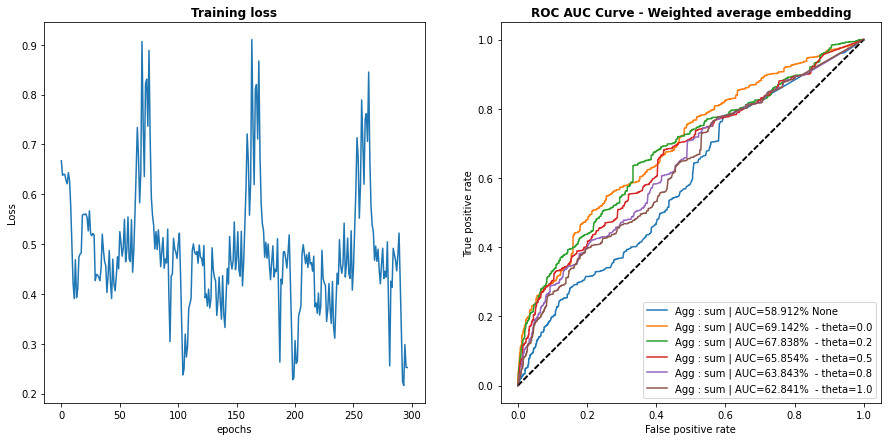

In [525]:
# -- Test --
history_fourier, test_pos_score, test_neg_score = test(mem, test_pos_g, test_neg_g, return_all=True)
history_fourier['fourier'] = {'test_auc': history_fourier['test_auc'], 
                      'test_fpr': history_fourier['test_fpr'],
                      'test_tpr': history_fourier['test_tpr']}

# Training loss
hist_train_loss = [float(x) for x in history['train_loss']]
hist_train_loss_epoch = hist_train_loss[::95]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plot_history_loss(hist_train_loss_epoch, ax[0])
ax[0].set_xlabel('epochs')
plot_auc(history_fourier.get('fourier'), ax=ax[1], title='DTFT features')


# -- Average embedding with weigth decay --
thetas = [0., 0.2, 0.5, 0.8, 1.]
res_w_tot = []
for theta in thetas:
    res_w = torch.zeros(history['embedding'][0].shape)
    for idx, emb in enumerate(history['embedding']):
        res_w += np.exp(-theta * (len(history['embedding']) - idx)) * emb
    res_w_tot.append(res_w/len(emb))

# -- Test weighted --
for idx, theta in enumerate(thetas):
    history_fourier_w, test_pos_score, test_neg_score = test(res_w_tot[idx], test_pos_g, test_neg_g, return_all=True)
    history_fourier_w['fourier'] = {'test_auc': history_fourier_w['test_auc'], 
                          'test_fpr': history_fourier_w['test_fpr'],
                          'test_tpr': history_fourier_w['test_tpr']}
    plot_auc(history_fourier_w.get('fourier'), ax=ax[1], title='Weighted average embedding', label=f' - theta={theta}')

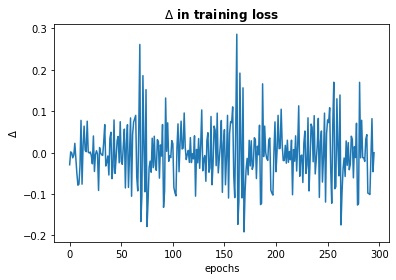

In [530]:
delta_hist_train_loss_epoch = [curr - old for curr, old in zip(hist_train_loss_epoch[1:], hist_train_loss_epoch[:-1])]
plt.plot(delta_hist_train_loss_epoch)
plt.title('$\Delta$ in training loss', weight='bold')
plt.ylabel('$\Delta$')
plt.xlabel('epochs');

**Using different optimizers**

In [ ]:
%%time

embedding_dimension = 16 
history = defaultdict(list)

# Model initialization
gcn_model = GCNModel(batch_pos_g.ndata['feat'].shape[1], embedding_dimension)
pred = CustomDotPredictor()
 
# Initialize memory of model
prev_memory = torch.zeros((train_pos_g.number_of_nodes(), embedding_dimension), requires_grad=True)
mem_model = MemoryModel(prev_memory.shape[0], embedding_dimension)

# Optimizer
optimizer_gcn = torch.optim.Adam(itertools.chain(gcn_model.parameters()), lr=0.001)
optimizer_mem = torch.optim.Adam(itertools.chain(mem_model.parameters()), lr=0.001)

visited_nodes = set()
# -- Training --
nb_epoch = 2
for epoch in range(nb_epoch):
    # Iterates over batches (except the first one which contains only self applied edges)
    for idx, (batch_pos_g, batch_neg_g) in enumerate(zip(train_batches[1:], train_neg_batches_reduced[1:])):
        #print(f'---- Batch N°{idx} ----')
        # Forward
        emb_N = gcn_model(batch_pos_g, batch_pos_g.ndata['feat'].to(torch.float32))
        curr_memory = mem_model(batch_pos_g, prev_memory)
        emb_tot = (emb_N + curr_memory)/2
        
        # Tracks visited nodes (i.e nodes that are source or destination of an edge)
        # For the others nodes, embedding is forced to 0
        #visited_nodes.update(set(batch_pos_g.edges()[0].numpy()).union(set(batch_pos_g.edges()[1].numpy())))
        #for node in range(emb_tot.shape[0]):
        #    if node not in visited_nodes:
        #        emb_tot[node, :] = 0
        
        pos_score = pred(batch_pos_g, emb_tot)
        neg_score = pred(batch_neg_g, emb_tot)
        loss_gcn = compute_loss(pos_score, neg_score)
        mse = nn.MSELoss()
        loss_mem = mse(curr_memory, emb_N)
        
        # Update memory
        #prev_memory = torch.from_numpy(emb_N.detach().numpy())
        
        # Save results
        history['train_loss'].append(loss.detach().numpy())

        # Backward
        optimizer_gcn.zero_grad() # zero the parameter gradients
        optimizer_mem.zero_grad()
        loss_gcn.backward()
        loss_mem.backward()
        optimizer_gcn.step()
        #optimizer_mem.step()
                
        if idx > 50:
            break
    #if epoch % 10 == 0:
    #    print(f'Training loss : {loss}')

In [1429]:
# -- Test --
history_stack, test_pos_score, test_neg_score = test(emb_tot, test_pos_g, test_neg_g, return_all=return_all)
history_stack['stack'] = {'test_auc': history_stack['test_auc'], 
                      'test_fpr': history_stack['test_fpr'],
                      'test_tpr': history_stack['test_tpr']}

AUC 0.5308568735591834


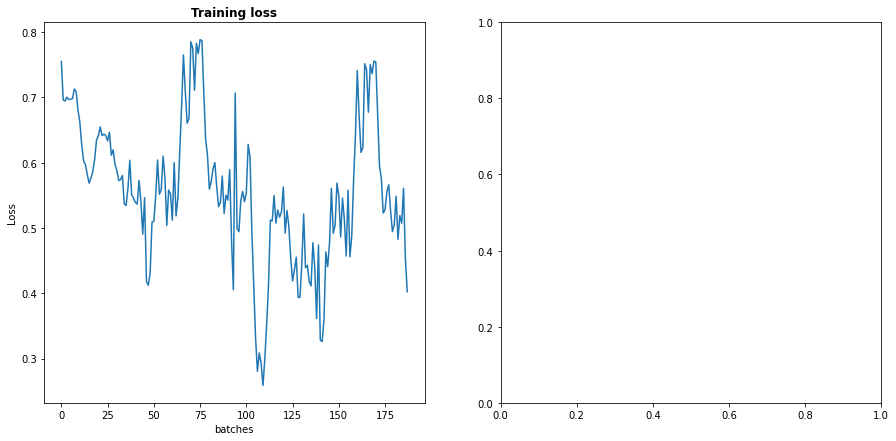

In [1430]:
# Training loss
hist_train_loss = [float(x) for x in history['train_loss']]
# Embedding variations  
#deltas_emb = [np.linalg.norm(prev.detach().numpy() - curr.detach().numpy(), ord='fro') for prev, curr in zip(history['embedding'][:-1], history['embedding'][1:])]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plot_history_loss(hist_train_loss, ax[0])

## Annexes

In [376]:
# Compute validation time and test time
val_time, test_time = np.quantile(g.edata['timestamp'], [0.7, 0.85])

# Split edge set for training, validation and test
source, dest = g.edges()

# Define masks
train_mask = g.edata['timestamp'] <= val_time
val_mask = torch.logical_and(g.edata['timestamp'] > val_time, g.edata['timestamp'] <= test_time)
test_mask = g.edata['timestamp'] > test_time

eids = np.arange(g.number_of_edges())
val_nb_edge = len(source[val_mask])
test_nb_edge = len(source[test_mask])
train_nb_edge = len(eids) - test_nb_edge - val_nb_edge

# Nodes for positive edges
train_pos_nodes = torch.cat([source[train_mask], dest[train_mask]]).unique()
val_pos_nodes = torch.cat([source[val_mask], dest[val_mask]]).unique()
test_pos_nodes = torch.cat([source[test_mask], dest[test_mask]]).unique()

# Nodes for negative edges
adj = sp.coo_matrix((np.ones(len(source)), (source.numpy(), dest.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_source_idx, neg_dest_idx = np.where(adj_neg != 0)
# Sample as much negative edges than positive
neg_eids = np.random.choice(len(neg_source_idx), g.number_of_edges())

train_neg_nodes = torch.cat([source[neg_source_idx[neg_eids[:train_nb_edge]]], 
                             dest[neg_dest_idx[neg_eids[:train_nb_edge]]]]).unique()
val_neg_nodes = torch.cat([source[neg_source_idx[neg_eids[val_nb_edge:test_nb_edge]]], 
                            dest[neg_dest_idx[neg_eids[val_nb_edge:test_nb_edge]]]]).unique()
test_neg_nodes = torch.cat([source[neg_source_idx[neg_eids[test_nb_edge:]]], 
                            dest[neg_dest_idx[neg_eids[test_nb_edge:]]]]).unique()

# Build training graph (ie. graph without test edges)
train_g = dgl.remove_edges(g, eids[train_nb_edge:])

In [120]:
val_time, test_time = list(np.quantile(g.edata['timestamp'], [0.70, 0.85]))

In [386]:
def train_test_split(g, val_size=0.15, test_size=0.15):

    # Compute validation time and test time
    val_cut = 1 - val_size - test_size
    test_cut = 1 - test_size
    val_time, test_time = np.quantile(g.edata['timestamp'], [val_cut, test_cut])

    # Split edge set for training, validation and test
    # Edges are divided into 2 groups : positive (link in graph) and negative (no link in graph)

    source, dest = g.edges()

    # Masks for datasets filtering
    train_mask = g.edata['timestamp'] <= val_time
    val_mask = torch.logical_and(g.edata['timestamp'] > val_time, g.edata['timestamp'] <= test_time)
    test_mask = g.edata['timestamp'] > test_time

    eids = np.arange(g.number_of_edges())
    val_nb_edge = len(source[val_mask])
    test_nb_edge = len(source[test_mask])
    train_nb_edge = len(eids) - test_nb_edge - val_nb_edge

    # Positive edges
    train_pos_g = dgl.graph((source[train_mask], dest[train_mask]), num_nodes=g.number_of_nodes())
    val_pos_g = dgl.graph((source[val_mask], dest[val_mask]), num_nodes=g.number_of_nodes())
    test_pos_g = dgl.graph((source[test_mask], dest[test_mask]), num_nodes=g.number_of_nodes())

    # Negative edges
    adj = sp.coo_matrix((np.ones(len(source)), (source.numpy(), dest.numpy())))
    adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
    neg_source_idx, neg_dest_idx = np.where(adj_neg != 0)
    
    # Sample as much negative edges than positive edges
    neg_eids = np.random.choice(len(neg_source_idx), g.number_of_edges())
    val_cut = train_nb_edge + val_nb_edge

    train_neg_g = dgl.graph((neg_source_idx[neg_eids[:train_nb_edge]], neg_dest_idx[neg_eids[:train_nb_edge]]), num_nodes=g.number_of_nodes())
    val_neg_g = dgl.graph((neg_source_idx[neg_eids[train_nb_edge:val_cut]], neg_dest_idx[neg_eids[train_nb_edge:val_cut]]), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((neg_source_idx[neg_eids[val_cut:]], neg_dest_idx[neg_eids[val_cut:]]), num_nodes=g.number_of_nodes())

    # Build training graph (ie. graph without test and valid edges)
    train_g = dgl.remove_edges(g, eids[train_nb_edge:])

    return train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g

In [500]:
%%time

def sample_random_node(g, n):
    return int(np.random.choice(g.nodes().numpy(), n))

def sample_random_time(timerange, n, mask):
    return int(np.random.choice(timerange[mask], n))

def make_edge_list(src, dest, t, mask):
    return [(u, v, t) for u, v, t in zip(src[mask].numpy(), dest[mask].numpy(), t[mask].numpy())]

timestamp = g.edata['timestamp']
edge_list_train = make_edge_list(source, dest, timestamp, train_mask)
edge_list_val = make_edge_list(source, dest, timestamp, val_mask)
edge_list_test = make_edge_list(source, dest, timestamp, test_mask)
timerange = np.arange(int(g.edata['timestamp'].min()), int(g.edata['timestamp'].max()) + 20, 20)

train_mask_neg = timerange <= val_time
val_mask_neg = np.logical_and(timerange > val_time, timerange <= test_time)
test_mask_neg = timerange > test_time

# Negative edges - Training set
train_neg_edge = []
while len(train_neg_edge) < train_nb_edge:
    random_edge = (sample_random_node(g, 1), sample_random_node(g, 1), sample_random_time(timerange, 1, train_mask_neg))
    if random_edge not in edge_list_train:
        train_neg_edge.append(random_edge)
        
# Negative edges - Validation set
val_neg_edge = []
while len(val_neg_edge) < val_nb_edge:
    random_edge = (sample_random_node(g, 1), sample_random_node(g, 1), sample_random_time(timerange, 1, val_mask_neg))
    if random_edge not in edge_list_val:
        val_neg_edge.append(random_edge)
        
# Negative edges - Test set
test_neg_edge = []
while len(test_neg_edge) < test_nb_edge:
    random_edge = (sample_random_node(g, 1), sample_random_node(g, 1), sample_random_time(timerange, 1, test_mask_neg))
    if random_edge not in edge_list_test:
        test_neg_edge.append(random_edge)

CPU times: user 10min 31s, sys: 3.37 s, total: 10min 35s
Wall time: 10min 42s


In [513]:
train_src_id, train_dest_id, train_t = zip(*train_neg_edge)
train_neg_g = dgl.graph((train_src_id, train_dest_id), num_nodes=g.number_of_nodes())
train_neg_g.edata['timestamp'] = torch.tensor(train_t)
val_src_id, val_dest_id, val_t = zip(*val_neg_edge)
val_neg_g = dgl.graph((val_src_id, val_dest_id), num_nodes=g.number_of_nodes())
val_neg_g.edata['timestamp'] = torch.tensor(val_t)
test_src_id, test_dest_id, test_t = zip(*test_neg_edge)
test_neg_g = dgl.graph((test_src_id, test_dest_id), num_nodes=g.number_of_nodes())
test_neg_g.edata['timestamp'] = torch.tensor(test_t)

In [ ]:
test_nodes = torch.cat([data.edges()[0][trainval_div:], data.edges()[
                           1][trainval_div:]]).unique().numpy()